# <center>Visualizing Results of Trained Autoformers</center>

In [1]:
from collections import Counter
import os
os.chdir('../')

import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

from main import build_parser, AutoformerEstimator

In [2]:
DEVICE = torch.device(0)

In [3]:
def find_ckpt_synthetic(dataset, attn, dm, dff, lwin, nth=1): 
    exp_dir = '/usr2/home/yongyiw/ckpt/lstf/Synthetic/{}/EXP_{}.npy_tfM_fh_le96_ll48_lp192_mautoformer_attn{}_ein1_din1_dout1_dm{}_dff{}_nh8_ne2_nd1_lw{}_c3_t0_dr0.05_E6_B32_p2_lr0.0001_sch1'.format(
        dataset, dataset, attn, dm, dff, lwin
    )
    return os.path.join(exp_dir, os.listdir(exp_dir)[nth], 'ckpt.pt')

def find_ckpt_real(dataset, dpath, lenc, llabel, lpred, attn, dim, lwin, nth=1): 
    exp_dir = '/usr2/home/yongyiw/ckpt/lstf/{}/autoformer/EXP_{}_tfM_fh_le{}_ll{}_lp{}_mautoformer_attn{}_ein{}_din{}_dout{}_dm512_dff2048_nh8_ne2_nd1_lw{}_c3_t1_dr0.05_E6_B32_p2_lr0.0001_sch1/'.format(
        dataset, os.path.basename(dpath), lenc, llabel, lpred, attn, dim, dim, dim, lwin
    )
    return os.path.join(exp_dir, os.listdir(exp_dir)[nth], 'ckpt.pt')

## Prediction Plots

### Synthetic Dataset

In [4]:
DATASETS = ['sinx', 'sinx_sin2x_sin4x', 'xsinx', 'sinx_c', 'x', 'sinx_x', 'sinx_x2_sym', 'sinx_x2_asym', 'sinx_sqrtx']
LEN_ENC = 96
LEN_LABEL = 48
LEN_PRED = 192
D_MODEL = 128 # 512
D_FF = 512 # 2048
START = 700

100%|██████████| 45/45 [00:01<00:00, 25.89it/s]


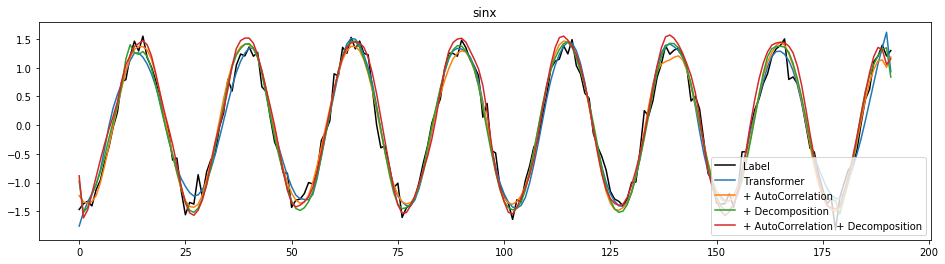

100%|██████████| 45/45 [00:01<00:00, 23.61it/s]


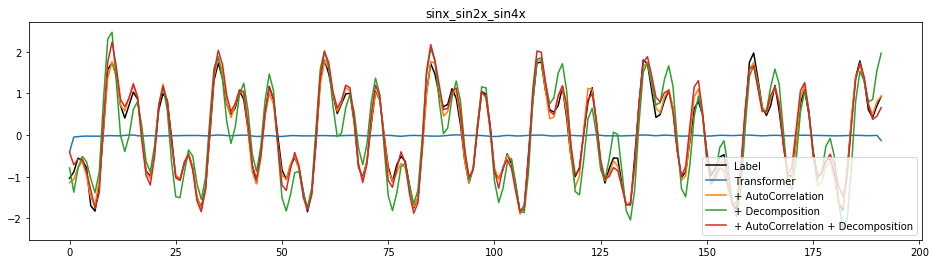

100%|██████████| 45/45 [00:01<00:00, 27.44it/s]


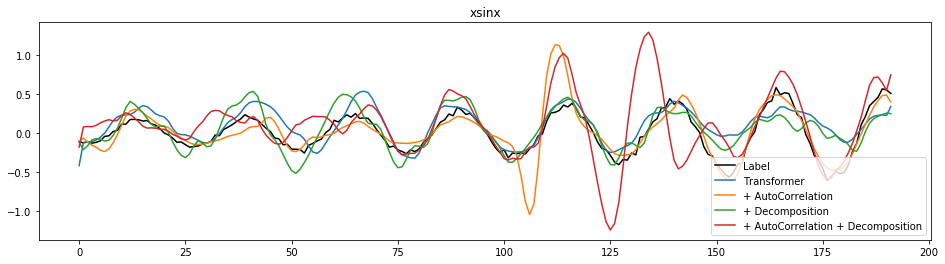

100%|██████████| 45/45 [00:01<00:00, 34.01it/s]


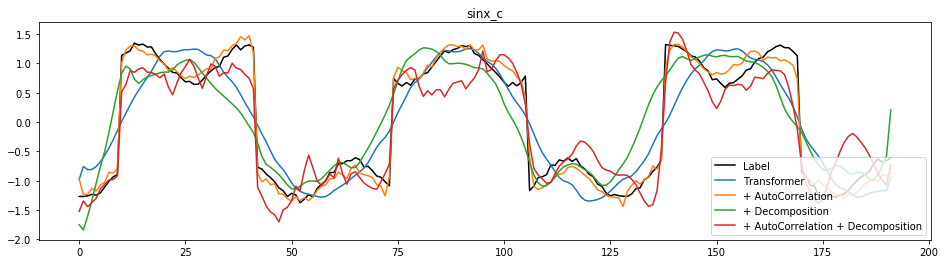

100%|██████████| 45/45 [00:01<00:00, 24.23it/s]


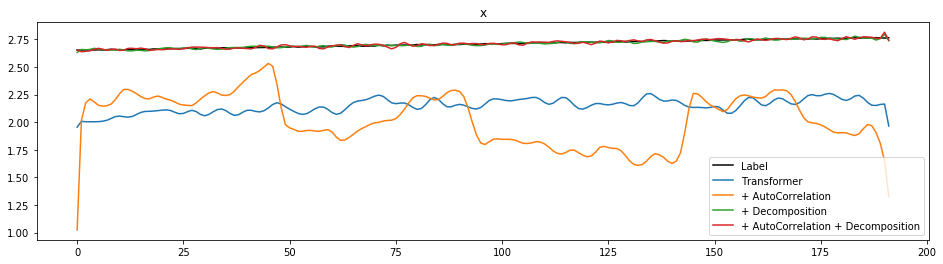

100%|██████████| 45/45 [00:01<00:00, 26.64it/s]


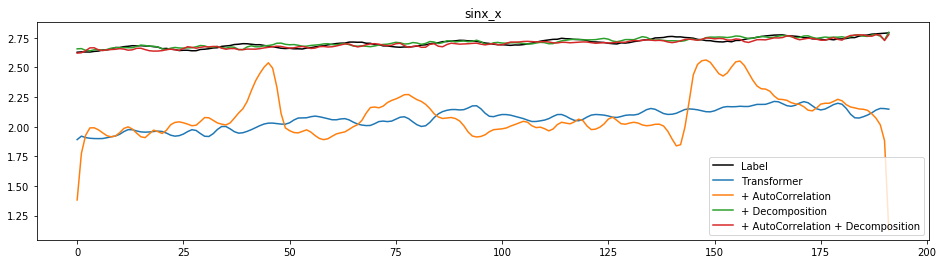

100%|██████████| 45/45 [00:01<00:00, 26.73it/s]


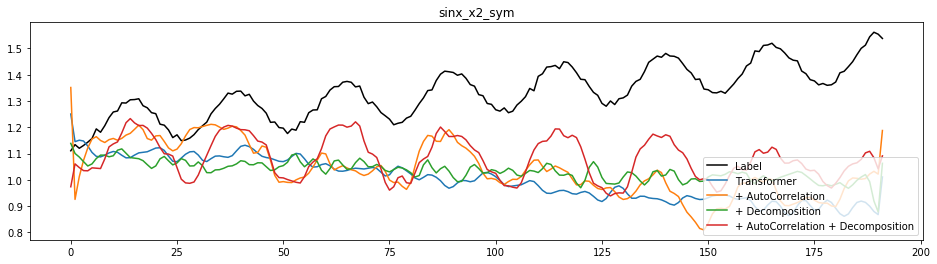

100%|██████████| 45/45 [00:01<00:00, 25.22it/s]


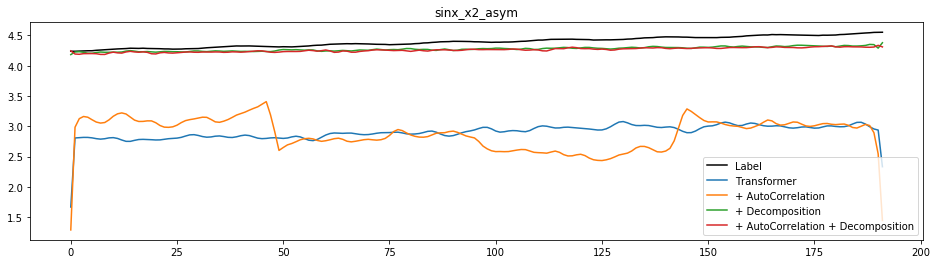

100%|██████████| 45/45 [00:01<00:00, 26.58it/s]


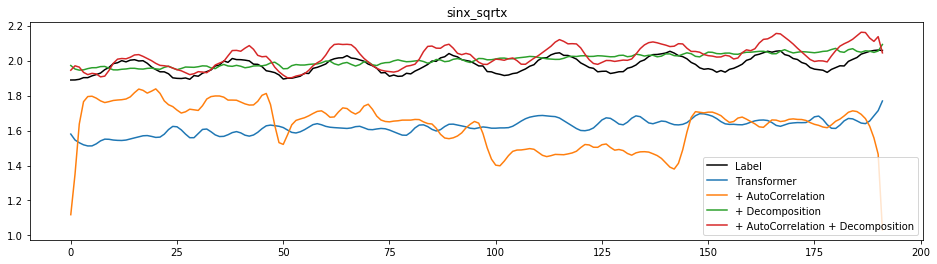

In [5]:
for dataset in DATASETS: 
    res = {}
    dpath = '/usr2/home/yongyiw/data/synth/{}.npy'.format(dataset)
    for attn in ['autocorrelation', 'dot']: 
        for lwin in [25, 0]: 
            parser = build_parser()
            cfg = parser.parse_args([
                '--data', 'Synthetic', 
                '--data_path', dpath, 
                '--ckpt', './temp', 
                '--len_enc', str(LEN_ENC), 
                '--len_label', str(LEN_LABEL), 
                '--len_pred', str(LEN_PRED), 
                '--model', 'autoformer', 
                '--attn', attn, 
                '--d_model', str(D_MODEL), 
                '--d_ff', str(D_FF), 
                '--n_enc_layers', '2', 
                '--n_dec_layers', '1', 
                '--len_window', str(lwin), 
                '--no_temporal', 
                '--lr_schedule', 
                '--devices', '0', '1', '2', '3', 
                '--no_verbose'
            ])
            cfg.config = ''

            estimator = AutoformerEstimator(cfg)
            _, _, testloader = estimator.get_data()
            _, yhats, ys = estimator.test(
                testloader, 
                find_ckpt_synthetic(dataset, attn, D_MODEL, D_FF, lwin, nth=0)
            )
            res[(attn, lwin)] = yhats
            os.system('rm -rf temp')
    res['y'] = ys
    
    plt.figure(figsize=(16, 4))
    plt.plot(res['y'][START, :], label='Label', color='black')
    plt.plot(res[('dot', 0)][START, :], label='Transformer')
    plt.plot(res[('autocorrelation', 0)][START, :], label='+ AutoCorrelation')
    plt.plot(res[('dot', 25)][START, :], label='+ Decomposition')
    plt.plot(res[('autocorrelation', 25)][START, :], label='+ AutoCorrelation + Decomposition')

    plt.title('{}'.format(dataset))
    plt.legend(loc='lower right')
    # plt.savefig('pred_{}.png'.format(dataset))
    plt.show()

### Real Dataset

In [6]:
DATASETS = ['ETTm2', 'Electricity', 'Exchange', 'Traffic', 'Weather', 'ILI']
CONFIG = {
    'ETTm2': {
        'dpath': '/usr2/home/yongyiw/data/ETT-small/ETTm2.csv', 
        'dim': 7
    }, 
    'Electricity': {
        'dpath': '/usr2/home/yongyiw/data/electricity/electricity.csv', 
        'dim': 321
    }, 
    'Exchange': {
        'dpath': '/usr2/home/yongyiw/data/exchange_rate/exchange_rate.csv', 
        'dim': 8
    }, 
    'Traffic': {
        'dpath': '/usr2/home/yongyiw/data/traffic/traffic.csv', 
        'dim': 862
    }, 
    'Weather': {
        'dpath': '/usr2/home/yongyiw/data/weather/weather.csv', 
        'dim': 21
    }, 
    'ILI': {
        'dpath': '/usr2/home/yongyiw/data/illness/national_illness.csv', 
        'dim': 7
    }
}
START = 42
DIM = -1

100%|██████████| 354/354 [00:15<00:00, 22.62it/s]


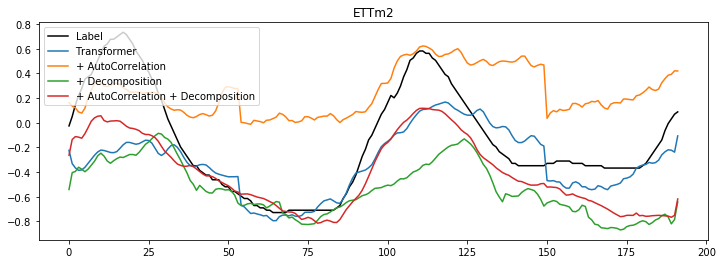

100%|██████████| 158/158 [00:10<00:00, 15.65it/s]


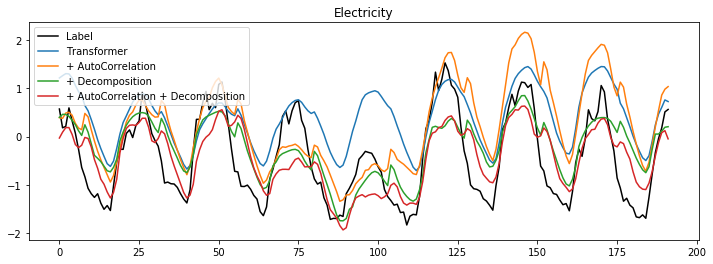

100%|██████████| 41/41 [00:01<00:00, 22.04it/s]


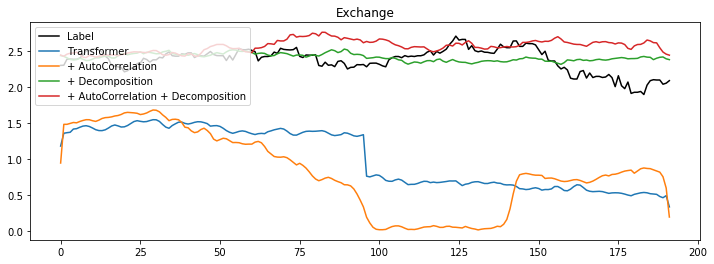

100%|██████████| 103/103 [00:07<00:00, 13.24it/s]


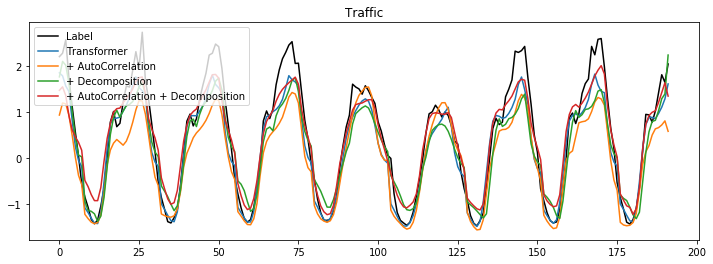

100%|██████████| 323/323 [00:14<00:00, 22.42it/s]


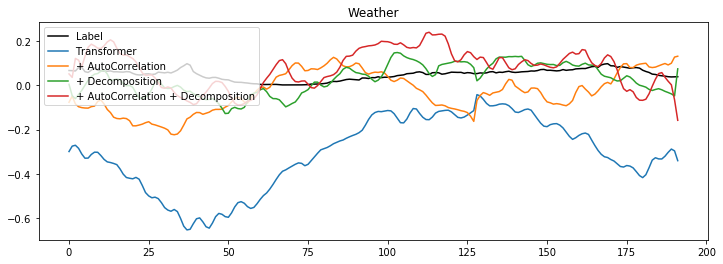

100%|██████████| 4/4 [00:00<00:00, 27.34it/s]


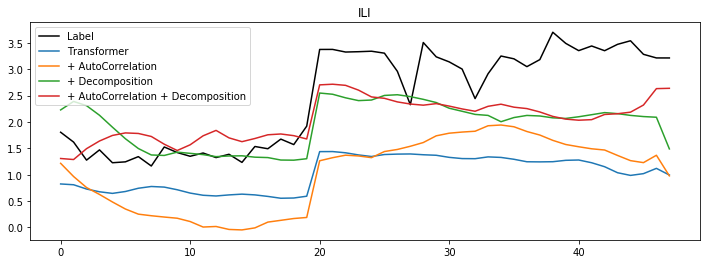

In [7]:
for dataset in DATASETS: 
    LEN_ENC = 96 if dataset != 'ILI' else 36
    LEN_LABEL = 48 if dataset != 'ILI' else 18
    LEN_PRED = 192 if dataset != 'ILI' else 48
    
    res = {}
    for attn in ['autocorrelation', 'dot']: 
        for lwin in [25, 0]: 
            parser = build_parser()
            cfg = parser.parse_args([
                '--data', dataset, 
                '--data_path', CONFIG[dataset]['dpath'], 
                '--ckpt', './temp', 
                '--len_enc', str(LEN_ENC), 
                '--len_label', str(LEN_LABEL), 
                '--len_pred', str(LEN_PRED), 
                '--model', 'autoformer', 
                '--attn', attn, 
                '--d_enc_in', str(CONFIG[dataset]['dim']), 
                '--d_dec_in', str(CONFIG[dataset]['dim']), 
                '--d_dec_out', str(CONFIG[dataset]['dim']), 
                '--n_enc_layers', '2', 
                '--n_dec_layers', '1', 
                '--len_window', str(lwin), 
                '--lr_schedule', 
                '--devices', '0', '1', '2', '3', 
                '--no_verbose'
            ])
            cfg.config = ''

            estimator = AutoformerEstimator(cfg)
            _, _, testloader = estimator.get_data()
            _, yhats, ys = estimator.test(
                testloader, 
                find_ckpt_real(dataset, CONFIG[dataset]['dpath'], LEN_ENC, LEN_LABEL, LEN_PRED, attn, CONFIG[dataset]['dim'], lwin)
            )
            res[(attn, lwin)] = yhats
            os.system('rm -rf temp')
    res['y'] = ys
    
    plt.figure(figsize=(12, 4))
    plt.plot(res['y'][START, :, DIM], label='Label', color='black')
    plt.plot(res[('dot', 0)][START, :, DIM], label='Transformer')
    plt.plot(res[('autocorrelation', 0)][START, :, DIM], label='+ AutoCorrelation')
    plt.plot(res[('dot', 25)][START, :, DIM], label='+ Decomposition')
    plt.plot(res[('autocorrelation', 25)][START, :, DIM], label='+ AutoCorrelation + Decomposition')

    plt.title('{}'.format(dataset))
    plt.legend(loc='upper left')
    # plt.savefig('pred_{}.png'.format(dataset))
    plt.show()

## Explainability of $\tau$

In [8]:
DATASETS = ['sinx', 'sinx_sin2x_sin4x', 'xsinx', 'sinx_c', 'x', 'sinx_x', 'sinx_x2_sym', 'sinx_x2_asym', 'sinx_sqrtx']
LEN_ENC = 96
LEN_LABEL = 48
LEN_PRED = 192
ENC_WEIGHTS = True
I_LAYER = 0
TOPK = 1

def step(model, data, counter): 
    enc_x = data['x'].to(DEVICE, dtype=torch.float)
    enc_x_time = data['x_time'].to(DEVICE, dtype=torch.float)
    y = data['y'].to(DEVICE, dtype=torch.float)
    dec_y_time = data['y_time'].to(DEVICE, dtype=torch.float)
    dec_y_s, dec_y_t = estimator.get_dec_input(enc_x, y)

    _, ((enc_self_weights, _), (dec_self_weights, dec_cross_weights)) = model(
        enc_x, enc_x_time, dec_y_s, dec_y_t, dec_y_time, 
        dec_self_mask=None
    )
    
    corr = (enc_self_weights if ENC_WEIGHTS else dec_self_weights)[I_LAYER]
    _, taus = torch.topk(torch.mean(corr, dim=-2), TOPK, dim=-1)
    counter.update(Counter(taus.cpu().reshape(-1).numpy()))

100%|██████████| 45/45 [00:01<00:00, 23.13it/s]


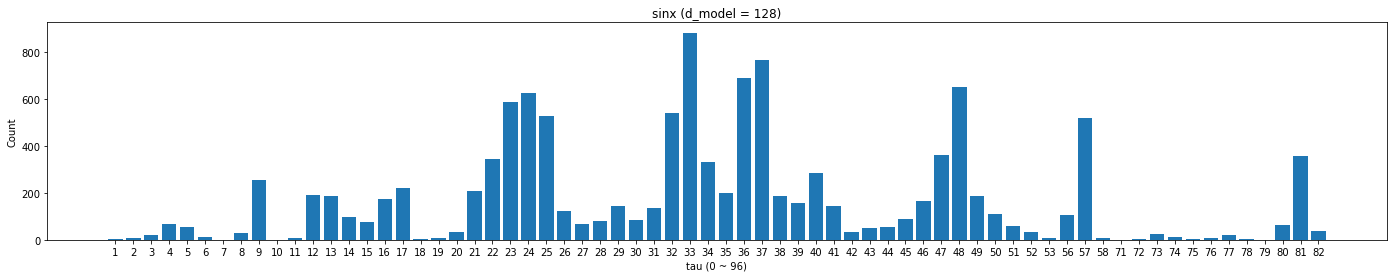

100%|██████████| 45/45 [00:02<00:00, 17.93it/s]


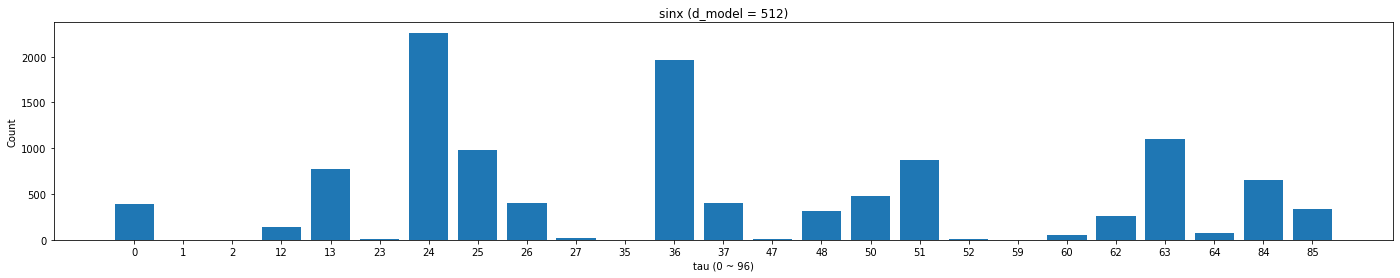

100%|██████████| 45/45 [00:02<00:00, 21.11it/s]


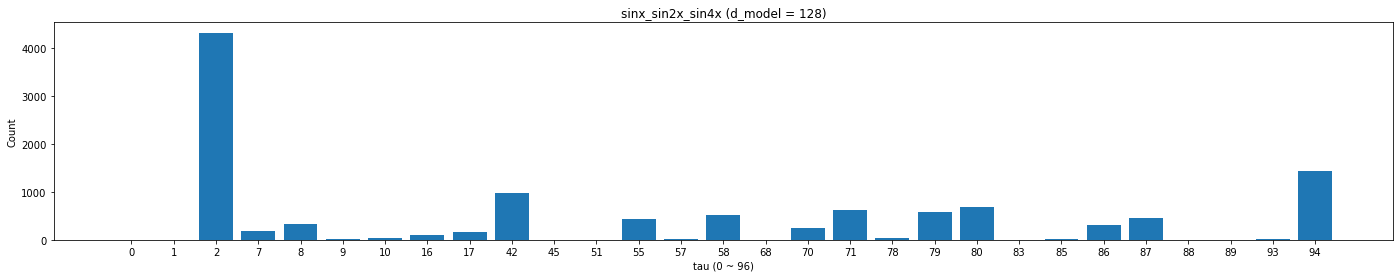

100%|██████████| 45/45 [00:02<00:00, 18.49it/s]


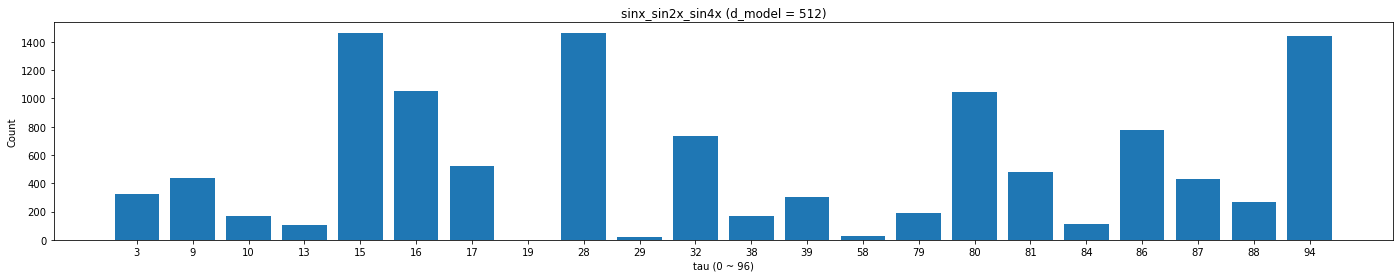

100%|██████████| 45/45 [00:02<00:00, 20.78it/s]


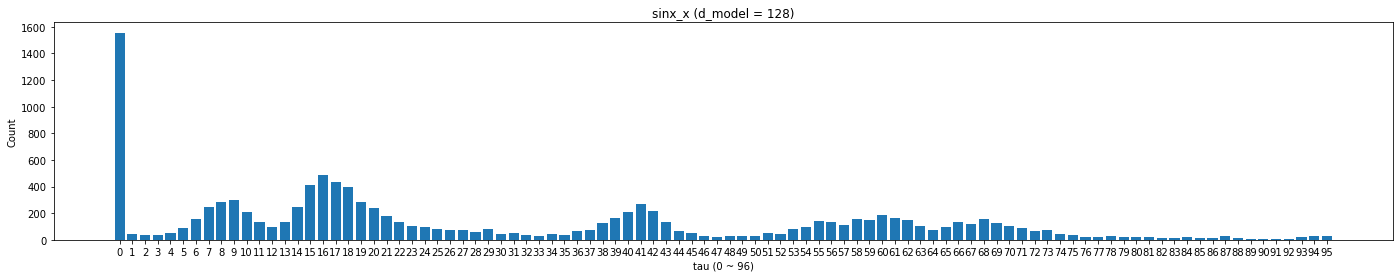

100%|██████████| 45/45 [00:02<00:00, 19.78it/s]


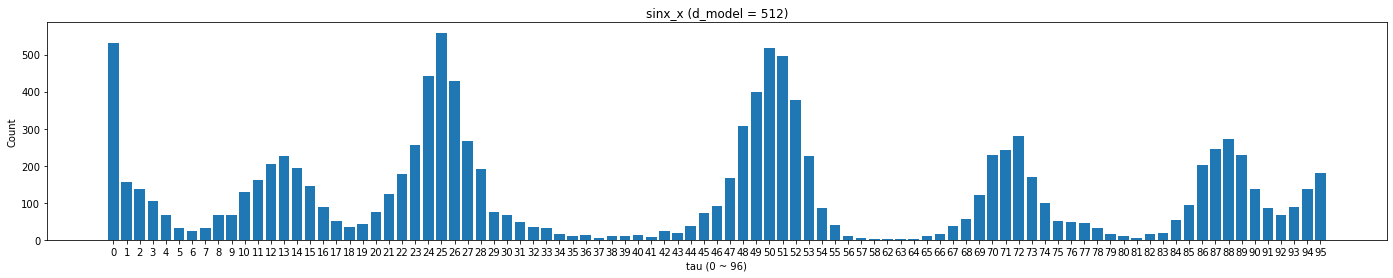

In [9]:
attn = 'autocorrelation'
lwin = 25

for dataset in ['sinx', 'sinx_sin2x_sin4x', 'sinx_x']: 
    for D_MODEL, D_FF in [(128, 512), (512, 2048)]: 
        counter = Counter()
        dpath = '/usr2/home/yongyiw/data/synth/{}.npy'.format(dataset)
        parser = build_parser()
        os.system('mkdir -p temp')
        cfg = parser.parse_args([
            '--data', 'Synthetic', 
            '--data_path', dpath, 
            '--ckpt', './temp', 
            '--len_enc', str(LEN_ENC), 
            '--len_label', str(LEN_LABEL), 
            '--len_pred', str(LEN_PRED), 
            '--model', 'autoformer', 
            '--attn', 'autocorrelation', 
            '--d_model', str(D_MODEL), 
            '--d_ff', str(D_FF), 
            '--n_enc_layers', '2', 
            '--n_dec_layers', '1', 
            '--len_window', '25', 
            '--no_temporal', 
            '--output_attn', 
            '--lr_schedule', 
            '--devices', '0', '1', '2', '3', 
            '--no_verbose'
        ])
        cfg.config = ''

        estimator = AutoformerEstimator(cfg)
        _, _, testloader = estimator.get_data()
        estimator.load(find_ckpt_synthetic(dataset, attn, D_MODEL, D_FF, lwin, nth=0))
        
        tbar = tqdm(testloader, dynamic_ncols=True)
        for data in tbar: 
            step(estimator.model, data, counter)
        os.system('rm -rf temp')

        labels, values = zip(*sorted(counter.items()))
        indexes = np.arange(len(labels))
        width = 0.8

        plt.figure(figsize=(24, 4))
        plt.bar(indexes, values, width)
        plt.xticks(indexes, labels)
        plt.title('{} (d_model = {})'.format(dataset, D_MODEL))
        plt.xlabel('tau (0 ~ 96)')
        plt.ylabel('Count')
        # plt.savefig('tau_{}_dm{}.png'.format(dataset, D_MODEL))
        plt.show()